# - Introducción
- ¿Qué es el polipropileno?

El polipropileno (PP) es un plástico termoplástico ampliamente utilizado en la industria.
Se obtiene a partir del propileno, un derivado del petróleo, y destaca por ser:

- ligero

- resistente químicamente

- fácil de moldear

- reutilizable y reciclable

Es uno de los polímeros más usados en el mundo.
Se emplea en envases, empaques, fibras textiles, automotriz, electrodomésticos, construcción, medicina, etc.

En la industria es común ver dos tipos principales:

- PP homopolímero

- PP copolímero

Ambos se comercializan como resina en forma de pellets.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go


In [ ]:
df = pd.read_csv("propileno.csv")
df

,Fecha,Precio
0,2024-11-25,7467.0
1,2024-11-26,7479.0
2,2024-11-27,7481.0
3,2024-11-28,7482.0
4,2024-11-29,7475.0
...,...,...
235,2025-11-14,6490.0
236,2025-11-17,6465.0
237,2025-11-18,6427.0
238,2025-11-19,6422.0


In [ ]:
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.set_index('Fecha')
df = df.asfreq('D').ffill()


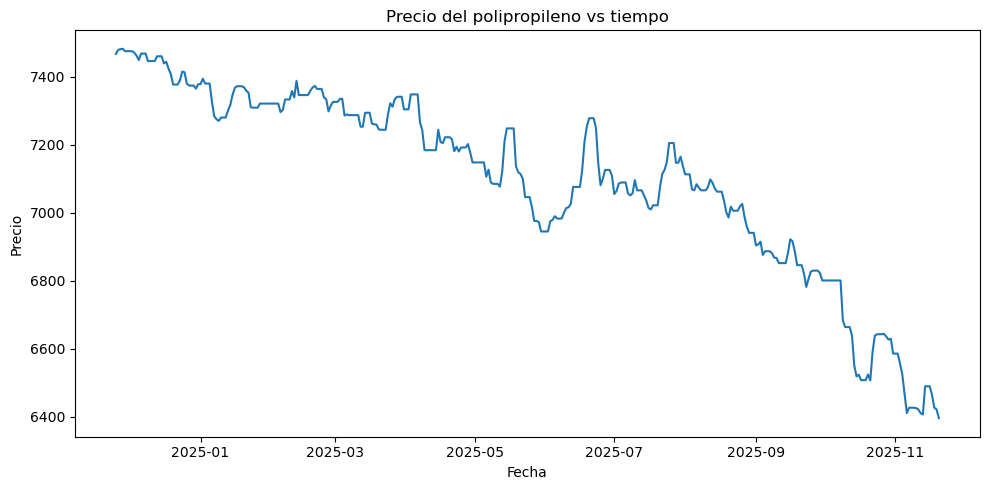

In [ ]:
# Gráfica de precio vs tiempo
plt.figure(figsize=(10,5))
plt.plot(df.index, df["Precio"])
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Precio del polipropileno vs tiempo")
plt.tight_layout()
plt.show()

## Escalamineto

In [ ]:
# --- Creación del escalador ---
normalizador = MinMaxScaler(feature_range=(0,1))

# --- Ajustar y transformar la serie ---
valores = df[["Precio"]].copy()
normalizador.fit(valores)
df["precio_norm"] = normalizador.transform(valores)
df.head()


,Precio,precio_norm
Fecha,,
2024-11-25,7467.0,0.986188
2024-11-26,7479.0,0.997238
2024-11-27,7481.0,0.999079
2024-11-28,7482.0,1.000000
2024-11-29,7475.0,0.993554


## Train/Test

In [ ]:
# --- Función para generar ventanas deslizantes ---
def create_sequences(series, window_size):
    X_list = []
    y_list = []

    max_start = len(series) - window_size

    for start_idx in range(max_start):
        end_idx = start_idx + window_size

        window = series[start_idx:end_idx]
        target = series[end_idx]

        X_list.append(window)
        y_list.append(target)

    X_array = np.array(X_list)
    y_array = np.array(y_list)

    return X_array, y_array

In [ ]:
serie_escalada = df["precio_norm"].values
proporcion_entreno = 0.8

# Calculamos el índice de corte
n_muestras = len(serie_escalada)
punto_corte = int(n_muestras * proporcion_entreno)

# División en subconjuntos
train_series = serie_escalada[:punto_corte]
test_series  = serie_escalada[punto_corte:]

print(f"Total datos   : {n_muestras}")
print(f"Train (80%)   : {len(train_series)}")
print(f"Test  (20%)   : {len(test_series)}")


Total datos   : 361
Train (80%)   : 288
Test  (20%)   : 73


### 20 días permite tener tendencia corta, patrones de subidas/bajadas recientes
### Si usamos una ventana muy grande, perdemos muchas muestras efectivas; si usamos una muy chica, el modelo ve muy poco contexto.

In [ ]:
# Definimos el tamaño de la ventana
window_size = 20

# Generamos secuencias para train y test
X_train, y_train = create_sequences(train_series, window_size)
X_test,  y_test  = create_sequences(test_series,  window_size)
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test  = X_test.reshape(X_test.shape[0],  window_size, 1)
X_train.shape, X_test.shape


((268, 20, 1), (53, 20, 1))

## LSTM

In [ ]:

# --- Modelo LSTM ---
lstm_model = Sequential()
lstm_model.add(Input(shape=(window_size, 1)))

# Primera capa LSTM
lstm_model.add(LSTM(
    units=72,
    return_sequences=True
))
lstm_model.add(Dropout(0.30))

# Segunda capa LSTM
lstm_model.add(LSTM(
    units=36,
    return_sequences=False
))
lstm_model.add(Dropout(0.30))

# Capa de salida
lstm_model.add(Dense(1))
lstm_model.compile(
    optimizer="adam",
    loss="mse"
)

lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 72)         │        21,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 36)             │        15,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,045 (144.71 KB)

 Trainable params: 37,045 (144.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback para parar temprano si ya no mejora
lstm_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# Entrenamiento del modelo
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[lstm_stop],
    verbose=1
)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0100 - val_loss: 0.0085
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0073 - val_loss: 0.0089
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0079 - val_loss: 0.0093
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0076 - val_loss: 0.0099
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

# CNN

In [ ]:
# --- Definición del modelo CNN ---
cnn_model = Sequential()

# Capa de entrada
cnn_model.add(Input(shape=(window_size, 1)))

# Bloque convolucional 1
cnn_model.add(Conv1D(
    filters=48,
    kernel_size=5,
    activation="relu",
    padding="same"
))

# Bloque convolucional 2
cnn_model.add(Conv1D(
    filters=32,
    kernel_size=3,
    activation="relu",
    padding="same"
))

# Pooling para reducir dimensionalidad
cnn_model.add(MaxPooling1D(pool_size=2))

# Otro bloque convolucional más ligero
cnn_model.add(Conv1D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="same"
))

# Pooling global
cnn_model.add(GlobalMaxPooling1D())

# Capa densa intermedia
cnn_model.add(Dense(32, activation="relu"))
cnn_model.add(Dropout(0.25))

# Capa de salida
cnn_model.add(Dense(1))

# Compilación del modelo
cnn_model.compile(
    optimizer="adam",
    loss="mse"
)

cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 20, 48)         │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 32)         │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,057 (27.57 KB)

 Trainable params: 7,057 (27.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

cnn_reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-6
)

history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[cnn_stop, cnn_reduce],
    verbose=1
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1265 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0284 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0262 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0230 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0201 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0165 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0164 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0123 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0171 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 10/1

## Tabla de hiperparametros probados

In [1]:
import pandas as pd

hyper_table = pd.DataFrame({
    "Modelo": [
        "LSTM", "LSTM", "LSTM", "LSTM",
        "CNN", "CNN", "CNN", "CNN"
    ],
    "Épocas": [50, 100, 200, 500,
               25, 50, 100, 250],
    "Batch size": [16, 16, 16, 16,
                   8, 8, 8, 8],
    "Optimizer": ["adam"] * 8,
    "Loss": ["mse", "mse", "mse", "mse",
             "mse", "mse", "mse", "mse"],
    "Dropout": ["0.30 / 0.30"] * 4 + ["0.25"] * 4,
    "Capas principales": [
        "LSTM(72, return_seq=True) + LSTM(36)",
        "LSTM(72, return_seq=True) + LSTM(36)",
        "LSTM(72, return_seq=True) + LSTM(36)",
        "LSTM(72, return_seq=True) + LSTM(36)",
        "Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",
        "Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",
        "Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",
        "Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",
    ],
    "Pooling": [
        "N/A", "N/A", "N/A", "N/A",
        "MaxPool1D(2) + GlobalMaxPool1D", 
        "MaxPool1D(2) + GlobalMaxPool1D",
        "MaxPool1D(2) + GlobalMaxPool1D",
        "MaxPool1D(2) + GlobalMaxPool1D"
    ],
    "Capa final Dense": ["Dense(1)"] * 8
})

hyper_table


,Modelo,Épocas,Batch size,Optimizer,Loss,Dropout,Capas principales,Pooling,Capa final Dense
0,LSTM,50,16,adam,mse,0.30 / 0.30,"LSTM(72, return_seq=True) + LSTM(36)",N/A,Dense(1)
1,LSTM,100,16,adam,mse,0.30 / 0.30,"LSTM(72, return_seq=True) + LSTM(36)",N/A,Dense(1)
2,LSTM,200,16,adam,mse,0.30 / 0.30,"LSTM(72, return_seq=True) + LSTM(36)",N/A,Dense(1)
3,LSTM,500,16,adam,mse,0.30 / 0.30,"LSTM(72, return_seq=True) + LSTM(36)",N/A,Dense(1)
4,CNN,25,8,adam,mse,0.25,"Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",MaxPool1D(2) + GlobalMaxPool1D,Dense(1)
5,CNN,50,8,adam,mse,0.25,"Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",MaxPool1D(2) + GlobalMaxPool1D,Dense(1)
6,CNN,100,8,adam,mse,0.25,"Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",MaxPool1D(2) + GlobalMaxPool1D,Dense(1)
7,CNN,250,8,adam,mse,0.25,"Conv1D(48,k5) + Conv1D(32,k3) + Conv1D(16,k3)",MaxPool1D(2) + GlobalMaxPool1D,Dense(1)


## Metricas de error

In [ ]:
def evaluate_model(model, X_data, y_data, scaler):
    pred_scaled = model.predict(X_data, verbose=0).reshape(-1)

    # Invertir escala
    pred_scaled = pred_scaled.reshape(-1, 1)
    true_scaled = y_data.reshape(-1, 1)

    # Invertir valores a escala real
    pred_real = scaler.inverse_transform(pred_scaled).flatten()
    true_real = scaler.inverse_transform(true_scaled).flatten()

    # Calcular métricas
    mse_val  = mean_squared_error(true_real, pred_real)
    mape_val = mean_absolute_percentage_error(true_real, pred_real) * 100

    return mse_val, mape_val, pred_real, true_real


# Evaluación
mse_lstm, mape_lstm, lstm_pred_real, y_true = evaluate_model(
    lstm_model, X_test, y_test, normalizador
)

mse_cnn, mape_cnn, cnn_pred_real, _ = evaluate_model(
    cnn_model, X_test, y_test, normalizador
)

print("===========================================")
print("          MÉTRICAS DE LOS MODELOS")
print("===========================================")
print(f"LSTM →  MSE:  {mse_lstm:.3f}    |  MAPE: {mape_lstm:.4f}%")
print(f"CNN  →  MSE:  {mse_cnn:.3f}    |  MAPE: {mape_cnn:.4f}%")
print("===========================================")



          MÉTRICAS DE LOS MODELOS
LSTM →  MSE:  4405.402    |  MAPE: 0.8158%
CNN  →  MSE:  17672.258    |  MAPE: 1.6561%


In [ ]:
time_axis = np.arange(len(y_true))

fig = go.Figure()

# Serie real
fig.add_trace(
    go.Scatter(
        x=time_axis,
        y=y_true,
        mode="lines",
        name="Real"
    )
)

# Predicción LSTM
fig.add_trace(
    go.Scatter(
        x=time_axis,
        y=lstm_pred_real,
        mode="lines",
        name="Predicción LSTM"
    )
)

# Predicción CNN
fig.add_trace(
    go.Scatter(
        x=time_axis,
        y=cnn_pred_real,
        mode="lines",
        name="Predicción CNN"
    )
)

fig.update_layout(
    title="Real vs Predicción (Conjunto de Test)",
    xaxis_title="Tiempo",
    yaxis_title="Precio Polipropileno",
    template="plotly_white"
)

fig.show()

## Predicciones

In [ ]:
# --- 1. Configuración del horizonte de predicción ---
forecast_horizon = 7

# Usamos toda la serie escalada para extraer la última ventana
scaled_series_full = df["precio_norm"].to_numpy()

# Últimos 'window_size' puntos como ventana inicial
last_window = scaled_series_full[-window_size:]
last_window = last_window.reshape(1, window_size, 1)  # (1, timesteps, features)


# --- 2. Función genérica para multi-step forecasting ---
def multi_step_forecast(model, initial_sequence, steps, window_size):
    sequence = initial_sequence.copy()
    preds_scaled = []

    for _ in range(steps):
        next_scaled = float(model.predict(sequence, verbose=0))
        preds_scaled.append(next_scaled)

        # Desplazar la ventana e insertar el nuevo valor al final
        sequence[:, :-1, :] = sequence[:, 1:, :]
        sequence[:, -1, 0] = next_scaled

    return np.array(preds_scaled)


# --- 3. Predicciones escaladas con ambos modelos ---
lstm_future_scaled = multi_step_forecast(
    lstm_model, last_window, forecast_horizon, window_size
)
cnn_future_scaled = multi_step_forecast(
    cnn_model, last_window, forecast_horizon, window_size
)

# --- 4. Desescalar las predicciones a precios reales ---
lstm_future_real = normalizador.inverse_transform(
    lstm_future_scaled.reshape(-1, 1)
).reshape(-1)

cnn_future_real = normalizador.inverse_transform(
    cnn_future_scaled.reshape(-1, 1)
).reshape(-1)

# --- 5. Construcción de las fechas futuras ---
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq="D"
)

# --- 6. DataFrame con el pronóstico ---
forecast_df = pd.DataFrame({
    "Fecha": future_dates,
    "LSTM_price": lstm_future_real,
    "CNN_price": cnn_future_real,
})

# Dejamos la fecha como índice
forecast_df = forecast_df.set_index("Fecha")

# Redondeamos para que se vea limpio
forecast_df = forecast_df.round(2)

forecast_df

C:\Users\david\AppData\Local\Temp\ipykernel_47364\3384806176.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_scaled = float(model.predict(sequence, verbose=0))


,LSTM_price,CNN_price,Mean_price
Fecha,,,
2025-11-21,6470.39,6593.96,6532.18
2025-11-22,6465.30,6589.86,6527.58
2025-11-23,6465.06,6595.60,6530.33
2025-11-24,6467.92,6604.60,6536.26
2025-11-25,6472.55,6612.88,6542.72
2025-11-26,6478.11,6616.86,6547.49
2025-11-27,6484.02,6620.78,6552.40


In [ ]:
import plotly.graph_objects as go

# --- Datos históricos: puedes ajustar cuántos días ver ---
history_days = 60  # cambia este valor si quieres ver más/menos
history_slice = df.iloc[-history_days:]
#history_slice = df

# --- Crear figura ---
fig = go.Figure()

# 1) Serie histórica
fig.add_trace(
    go.Scatter(
        x=history_slice.index,
        y=history_slice["Precio"],
        mode="lines",
        name="Historical price",
        line=dict(width=2)
    )
)

# 2) Predicción LSTM
fig.add_trace(
    go.Scatter(
        x=forecast_df.index,
        y=forecast_df["LSTM_price"],
        mode="lines+markers",
        name="LSTM forecast",
        line=dict(dash="dash"),
        marker=dict(size=6)
    )
)

# 3) Predicción CNN
fig.add_trace(
    go.Scatter(
        x=forecast_df.index,
        y=forecast_df["CNN_price"],
        mode="lines+markers",
        name="CNN forecast",
        line=dict(dash="dot"),
        marker=dict(size=6)
    )
)

# --- Layout / estilo ---
fig.update_layout(
    title="Polypropylene price – Historical vs 7-day forecasts (LSTM & CNN)",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

In [ ]:
# --- Fechas del test set ---
test_index = df.index[-len(y_test):]   # alineamos el test con las fechas reales

# --- Crear figura ---
fig = go.Figure()

# 1) Serie histórica completa
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["Precio"],
        mode="lines",
        name="Historical price",
        line=dict(width=2)
    )
)

# 2) Predicción LSTM sobre los datos que sí existen
fig.add_trace(
    go.Scatter(
        x=test_index,
        y=lstm_pred_real,
        mode="lines+markers",
        name="LSTM test prediction",
        line=dict(dash="dash"),
        marker=dict(size=5)
    )
)

# 3) Predicción CNN sobre datos existentes
fig.add_trace(
    go.Scatter(
        x=test_index,
        y=cnn_pred_real,
        mode="lines+markers",
        name="CNN test prediction",
        line=dict(dash="dot"),
        marker=dict(size=5)
    )
)

# --- Layout ---
fig.update_layout(
    title="Historical data vs Test Predictions (LSTM & CNN) – Checking for Data Leakage",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.01,
        xanchor="right",
        x=1
    )
)

fig.show()